
<h1>Machine Learning For HR Analytics</h1>


In [1]:
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font color='coral' size=4>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

<a id="Introduction"></a>
## 0. Introduction<br>

This report demonstrates the practice of Machine Learning methodologies on the classification problem of employees' turnover. The report will start with a brief look of the dataset `turnover.csv` from [kaggle](https://www.kaggle.com/lnvardanyan/hr-analytics).<br><br>
Then the report will perform some Explonatory Data Analysis along with some Data Preparation process. After generating a baseline model without any feature engineering, the report will forcus on performing feature enginnering and deriving to the final model.<br><br>
With the help of categorizing numeric features, generating polynomial features, and method of selecting best features, the final Logistic Regression model achieve's 96.33% accuracy on predicting an employee's turnover.

In [1]:

# @hidden_cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    cross_validate,ShuffleSplit,validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


## <h1>Table of Contents</h1>
* [0. Introduction](#Introduction)
* [1. Data Load](#DataLoad)
* [2. Data Preparation](#DataPreparation)
* [3. Data Visualization](#DataViz)
* [4. Baseline Model](#BaselineModel)
* [5. Feature Enginnering](#FeatureEnginnering)
* [6. Final Metric](#FinalMetric)


<a id="DataLoad"></a>
## 1. Data Load<br>

This dataset has 14999 rows and 10 columns. Besides the target binary field `left`, the dataset has 7 numeric features and 2 categorical features. Fortunately, the dataset does not contain any missing value. The ratio of the target `left` shows that the dataset is balanced. 23.8% of the employees left while the rest stayed.  


In [2]:
# @hidden_cell
# load data
data = pd.read_csv("../data/turnover.csv")
print("Basic information about the dataset:")
print(data.info())
###### need to check if the dataset is balanced
print('Missing values in the dataset:', data.isnull().sum().sum())
print("-------------------------------------------")
print('Employee left ratio:')
print(data.left.value_counts()/len(data))


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Missing values in the dataset: 0
-------------------------------------------
Employee left ratio:
0    0.761917
1    0.238083
Name: left, dtype: float64


The first five rows are loaded for further understanding of the dataset. The table in below shows that the numeric fields `number_project` and `time_spend_company` behave like categorical fields, while `Work_accident` and `promotion_last_5years` seem to be binary fields.

In [3]:
# @hidden_cell
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<a id="DataPreparation"></a>
## 2. Data Preparation<br>

Based on the insight of the unique values from those fields, we are able to identify them as categorical fields which has numerical meanings. As for now, we keep their original format. We will come back to these features in the further [feature engineering](#FeatureEnginnering) process.<br><br>
However, the result also indicates that `sales` and `salary` are the two categorical fields need to be processd before running the baseline model. As the `sales` contains the department names, including `sales` itself, we rename this field to `depts`, and unfold this categorical fields into dummies. In addition, one unfolded category, `management` is dropped because if the employee with all the department category fields equal to 0, then this employee must be in the managment department ~~(not necessary to explain dummy variable trap to them)~~. <br><br>
Even though the `salary` contains string values, the values have numeric scale. Instead of unfolding this field, we encode it to numeric values `0`,`1`, and,`2` with respect to `low`,`medium`, and `high`.

In [4]:
# @hidden_cell
for i in ['number_project','time_spend_company','Work_accident','promotion_last_5years','sales','salary']:
    print("Field's Name: ",i)
    print("Unique Values: ",data[i].sort_values().unique())
    print("--------------------------------")

Field's Name:  number_project
Unique Values:  [2 3 4 5 6 7]
--------------------------------
Field's Name:  time_spend_company
Unique Values:  [ 2  3  4  5  6  7  8 10]
--------------------------------
Field's Name:  Work_accident
Unique Values:  [0 1]
--------------------------------
Field's Name:  promotion_last_5years
Unique Values:  [0 1]
--------------------------------
Field's Name:  sales
Unique Values:  ['IT' 'RandD' 'accounting' 'hr' 'management' 'marketing' 'product_mng'
 'sales' 'support' 'technical']
--------------------------------
Field's Name:  salary
Unique Values:  ['high' 'low' 'medium']
--------------------------------


In [5]:
# @hidden_cell
data.rename(columns = {'sales':'depts'}, inplace = True)
# convert the datatype for cats
cat_cols = data.select_dtypes(['object']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.astype('category'))
# encode salary
data.salary = data.salary.cat.reorder_categories(['low','medium','high'])
data.salary = data.salary.cat.codes
# encode department, drop one avoid dummy trap
dept = pd.get_dummies(data.depts).drop("management", axis = 1)
dept_names = list(dept.columns)
data_c = data.drop('depts', axis = 1)
data_c = data_c.join(dept)
# data_c.head()

In [4]:
# # rescale average_montly_hours
# def minmaxdf(df):
#     df2 = (df-df.min())/(df.max()-df.min())
#     return df2
# data_c['average_montly_hours'] = pd.DataFrame(minmaxdf(data_c['average_montly_hours']), columns=['average_montly_hours'])
# print(data_c['average_montly_hours'].info())

<a id="DataViz"></a>
## 3. Data Visualization<br>

As a part of the Exploratory Data Analysis, the visualization of the dataset provides some interesting insight with respect to our focus **the turnover of the employees**.<br><br>
At this point, we decide not to fix the skewness of all the fields, because the skewness may also provide some useful information. Going through all the features with respect to employees' turnover, we find the employees' **satisfaction level**, **last evaluation**, **average monthly hours** to be important to their decision of turnover.<br><br>
In the plots shown below, we present the employee <font color="windows blue">stayed</font> and <font color=coral>left</font> in different colors, and the number of employees in different height of each bar.

In [10]:
# @hidden_cell
# skip the cats and target field
# col2skip = dept_names + ['left']
# for col in data_c.columns:
#     if col not in col2skip:
#         pd.crosstab(data_c[col],data_c['left']).plot(kind='bar', title=col, xticks = None)
#         plt.show()

cols2plot=['satisfaction_level','last_evaluation','average_montly_hours','time_spend_company']
def plotcols(col):
    sns.set(style="white", palette="muted", color_codes=True, font_scale=4)
    f, axes = plt.subplots(1, 1, figsize=(50, 20), sharex=True)
    splot1 = sns.distplot(data_c[col][data_c['left']==1],
                 kde=False, color="darkorange",
                 hist_kws={"alpha": 0.5})
    splot2 =  sns.distplot(data_c[col][data_c['left']==0], 
                 kde=False, color="blue",
                 hist_kws={"alpha": 0.5})
    axes.set_yticks([])
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    

The chart below shows the distribution of the employees' `satisfaction_level` with respect to turnover. Logically, employees tend to <font color=coral>leave</font>with low satisfaction level, and they tend to <font color="windows blue">stay</font> when the satisfaction level is high. Surprisingly, when the satisfaction level is between 0.2 and 0.3, employees tend to stay. Also, when the satisfaction level is between 0.7 and 0.9, there is no big difference between stay and left.

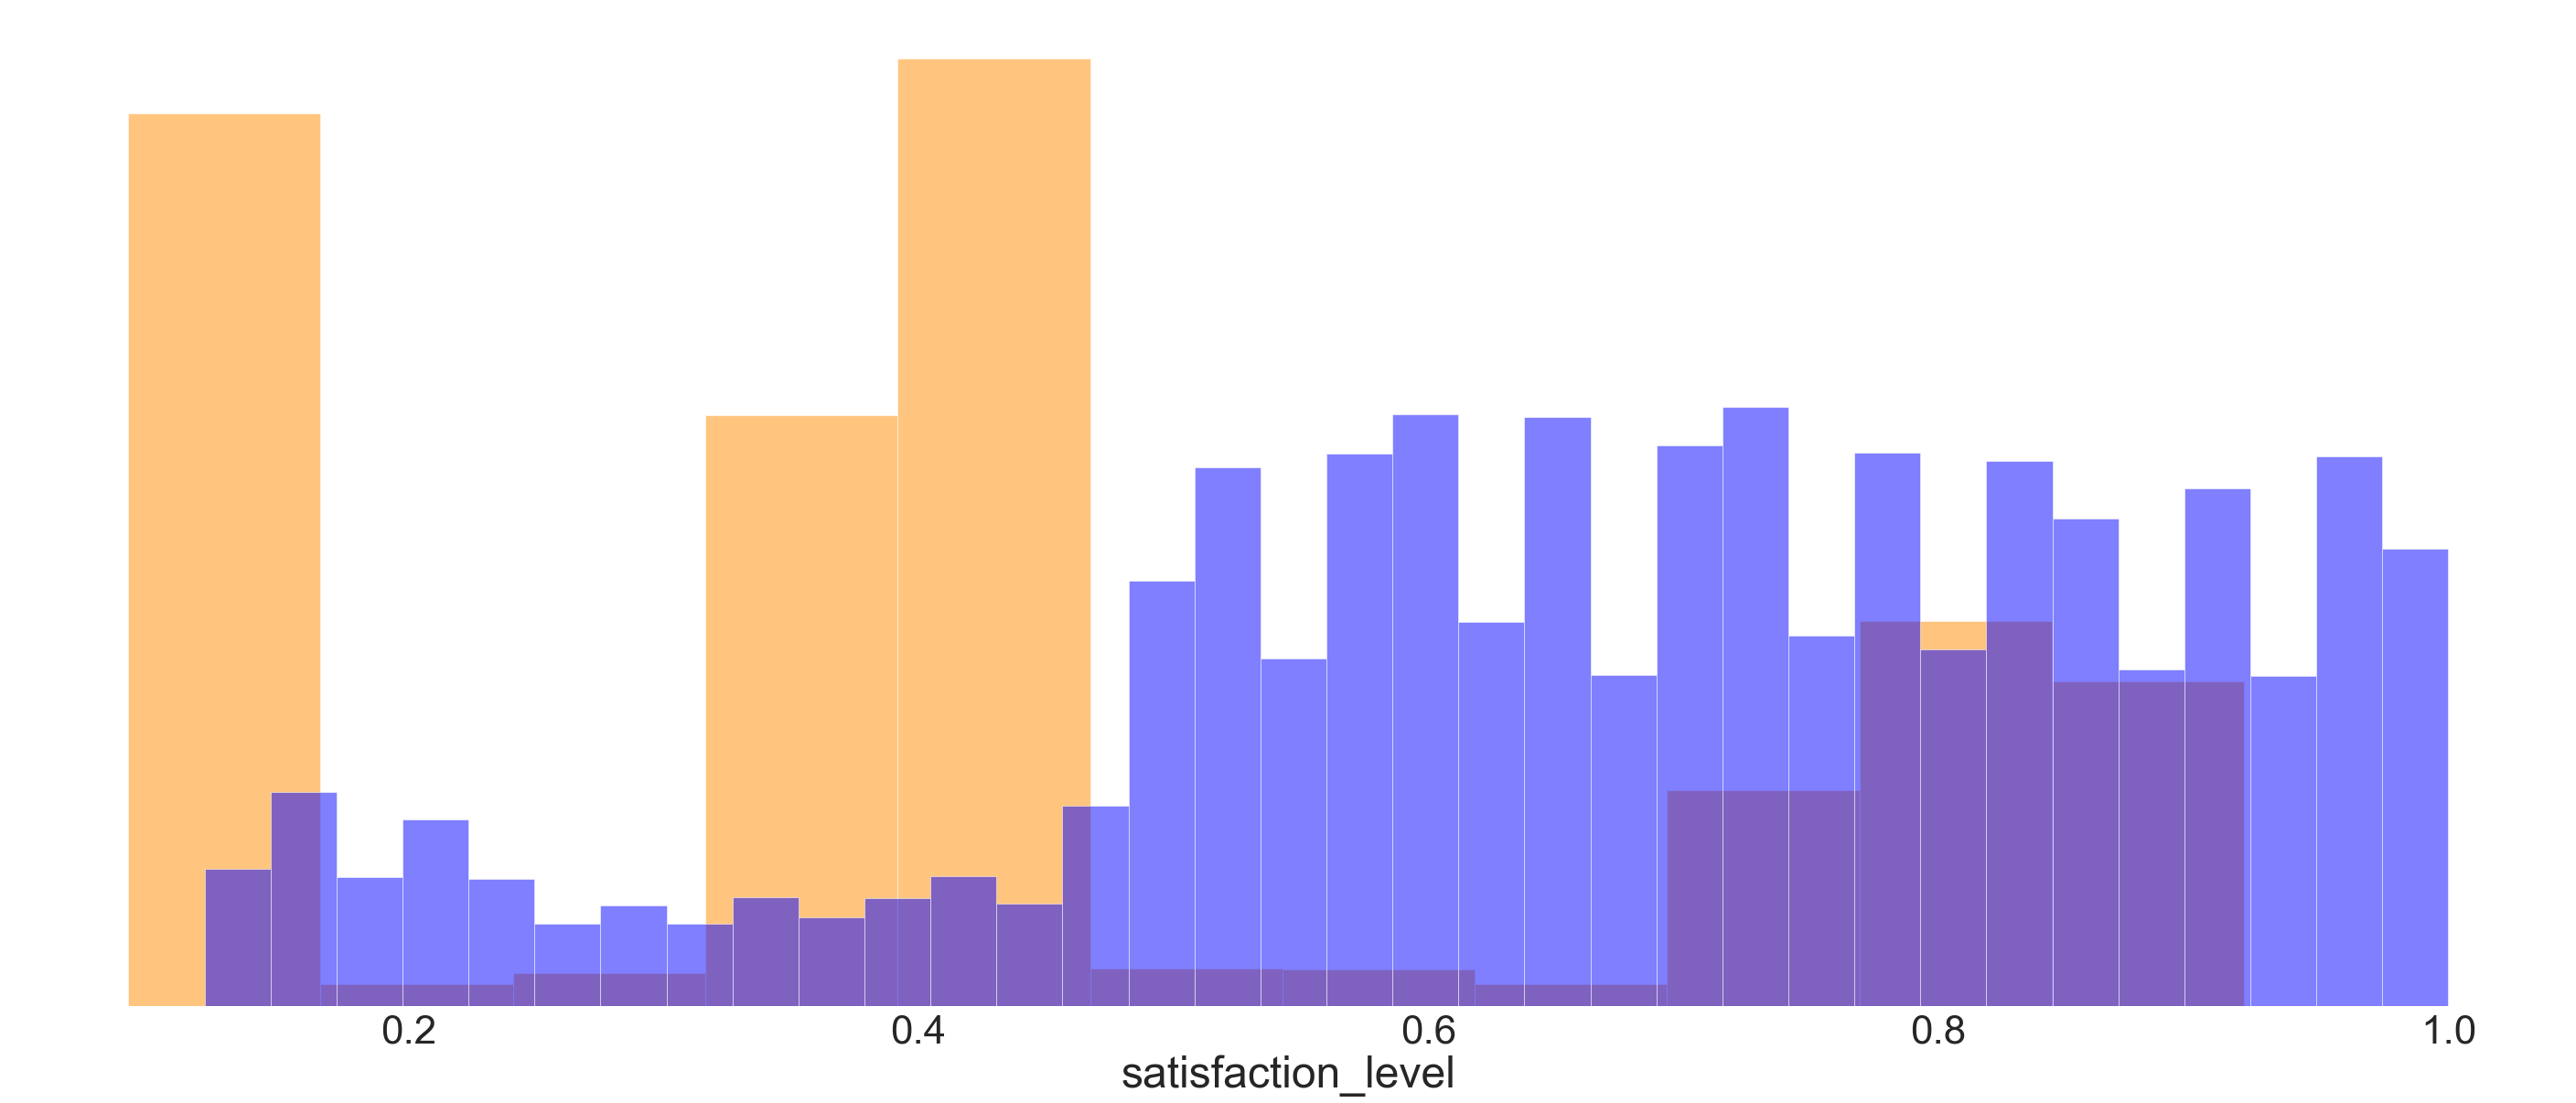

In [11]:
# @hidden_cell
plotcols(cols2plot[0])

The similar pattern appears in the distribution of `last_evaluation` as well. When the employee's last evaluation is between 0.45 and 0.6, and between 0.8 and 1.0, there is no big difference in employee's stay or left.

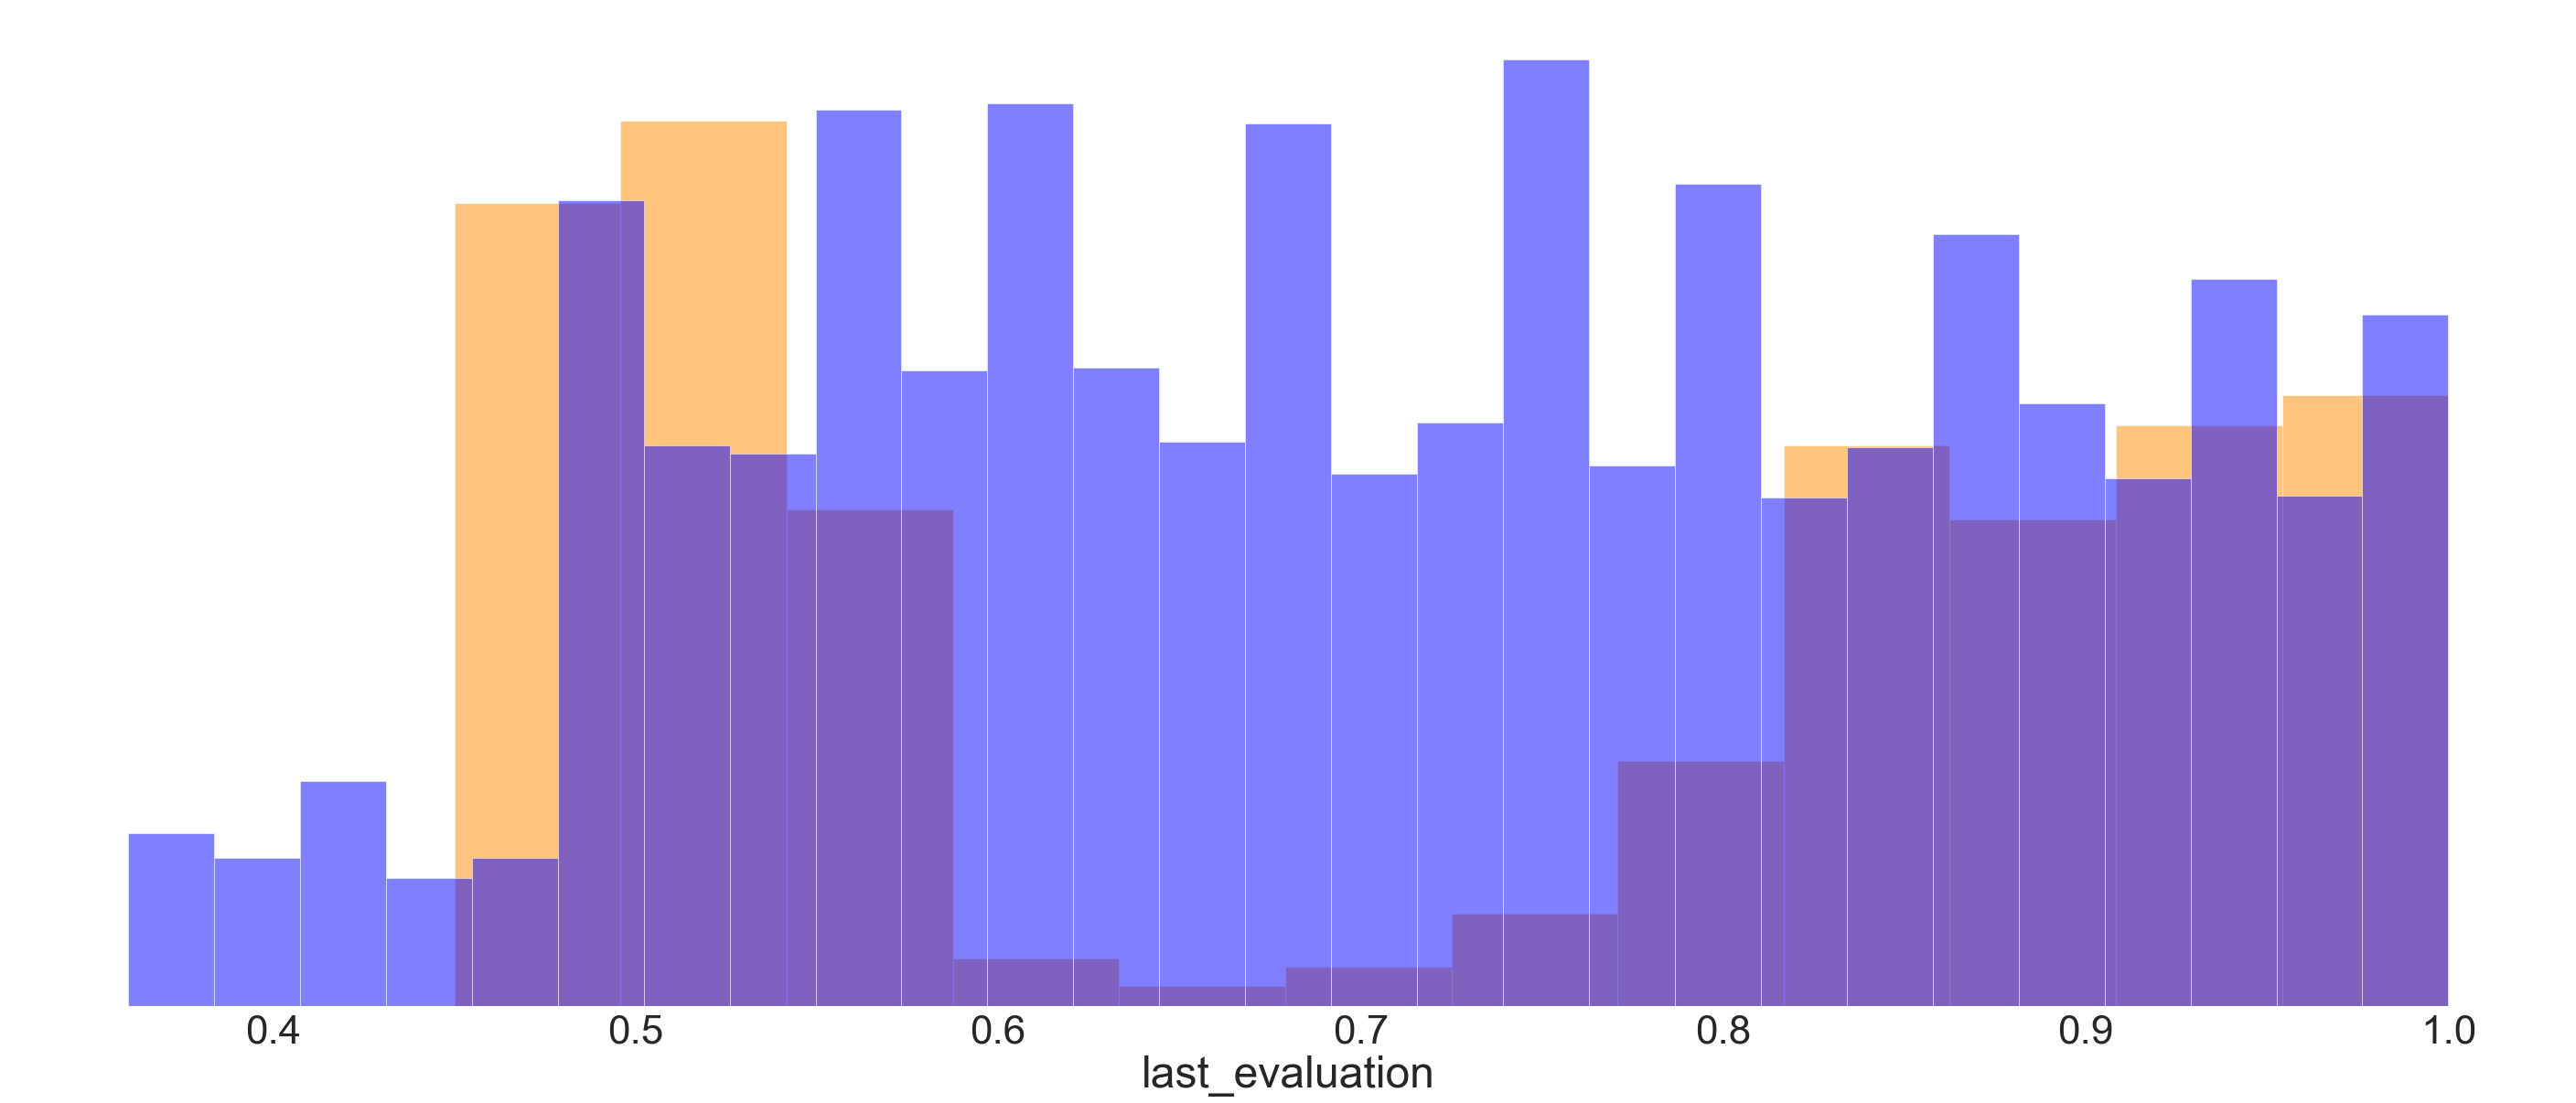

In [12]:
# @hidden_cell
plotcols(cols2plot[1])

Logically, employees are more likely to leave the company when the average monthly working hours are too long. It explains why the distribution shows only the <font color="windows blue">stayed</font> employees on the left tail, and the <font color=coral>left</font> employees on the right tail. However, the distribution also indicates that the employees tend to leave when the average monthly working hours are between 125 to 150.

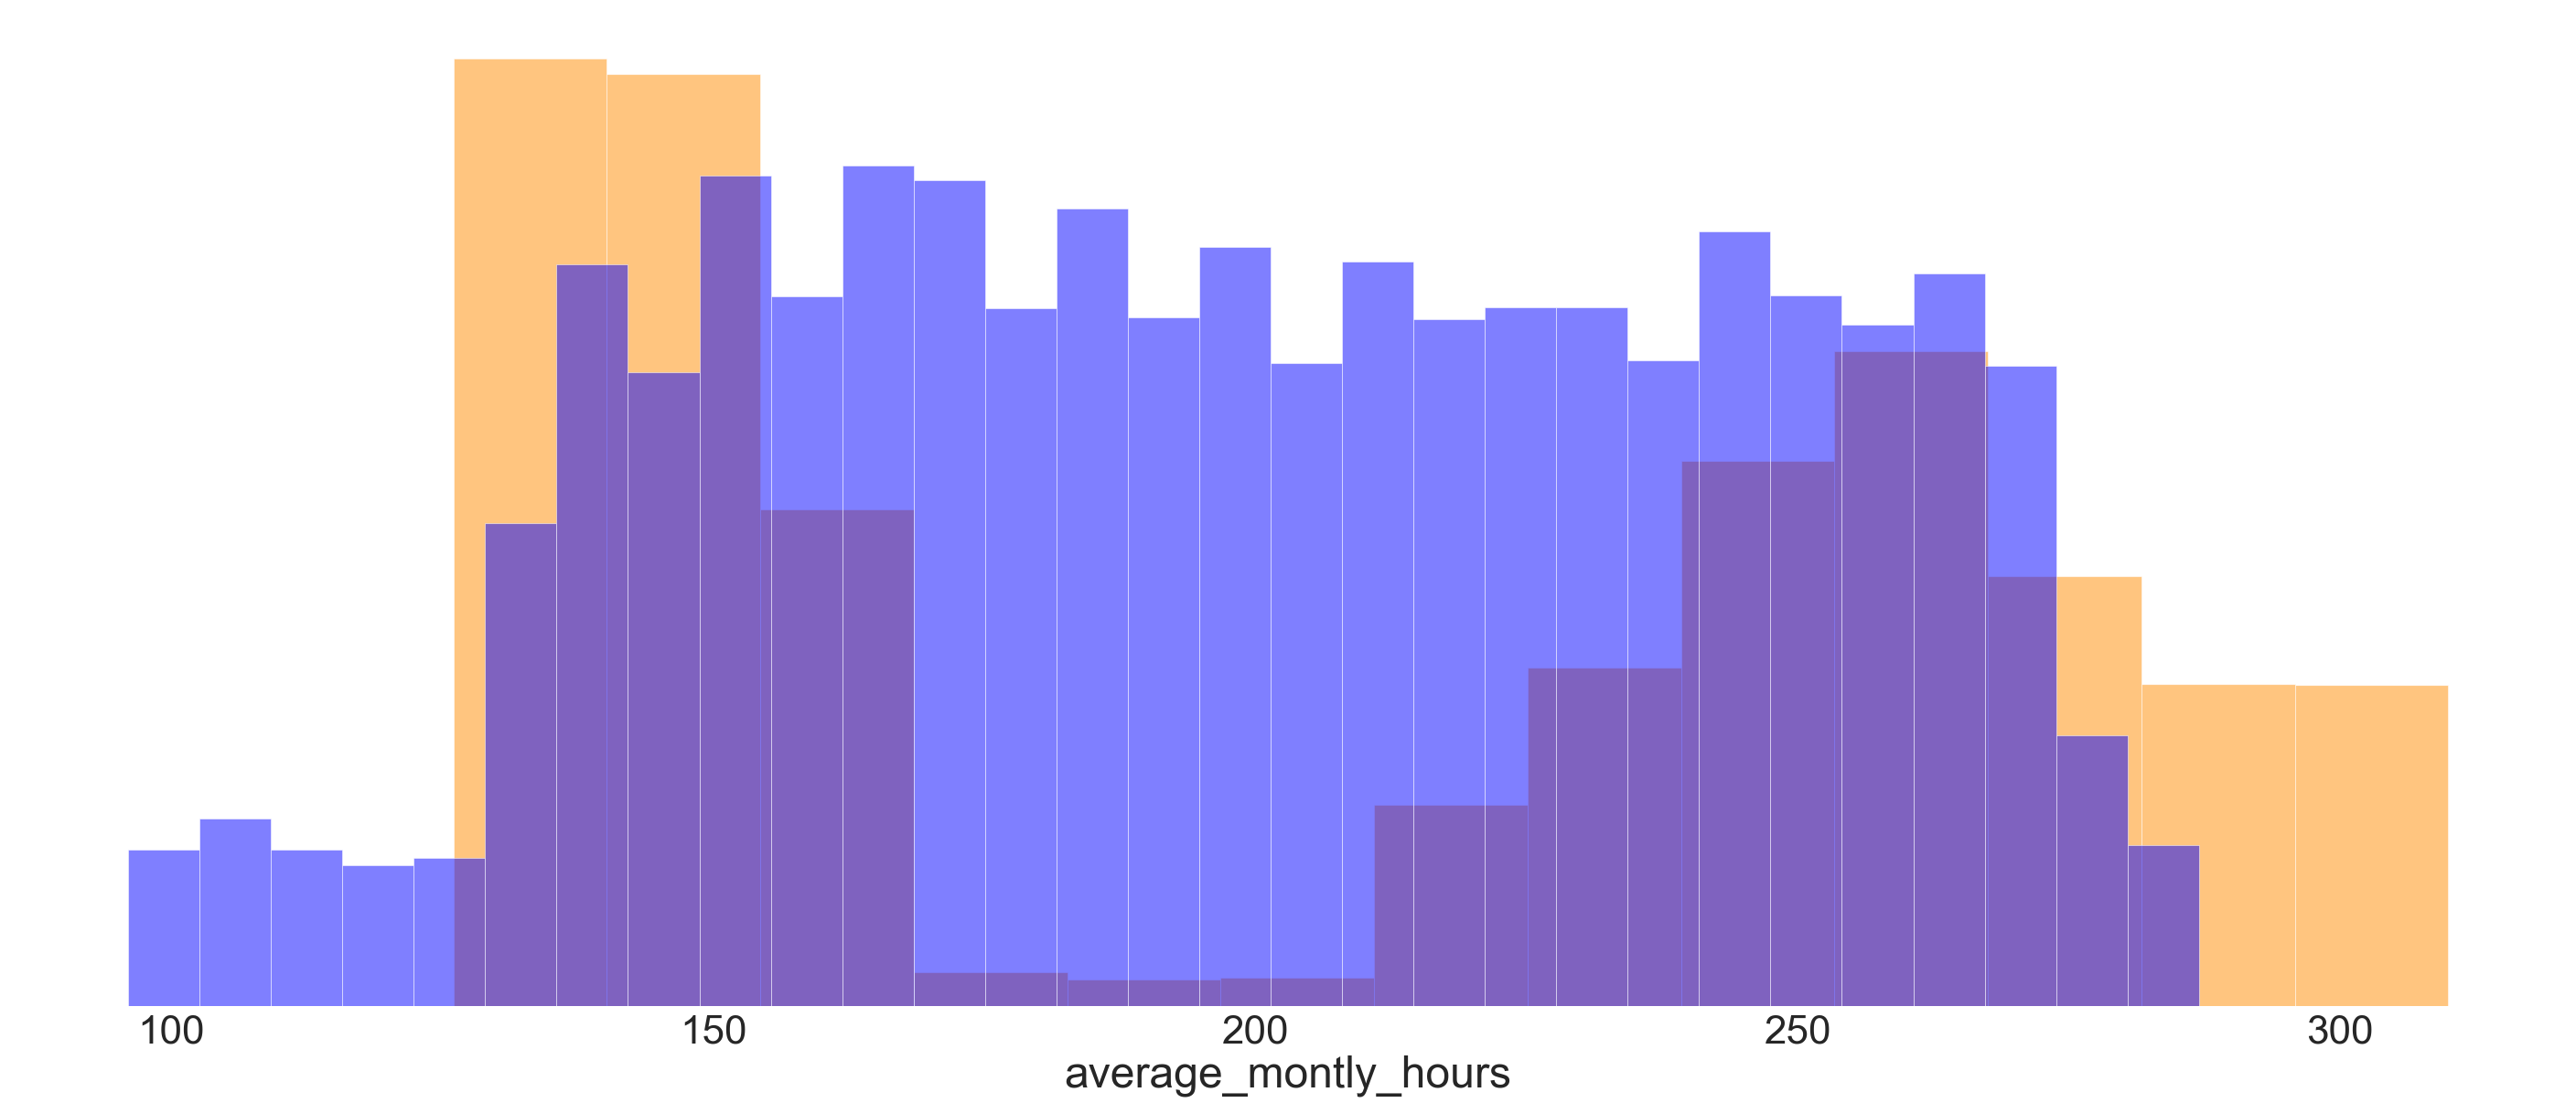

In [13]:
# @hidden_cell
plotcols(cols2plot[2])

The distribution of `time_spend_company` also shows an interesting insight. The employees, whose time spend in company reaches level 7 or lower than level 3, are not going to leave the company.

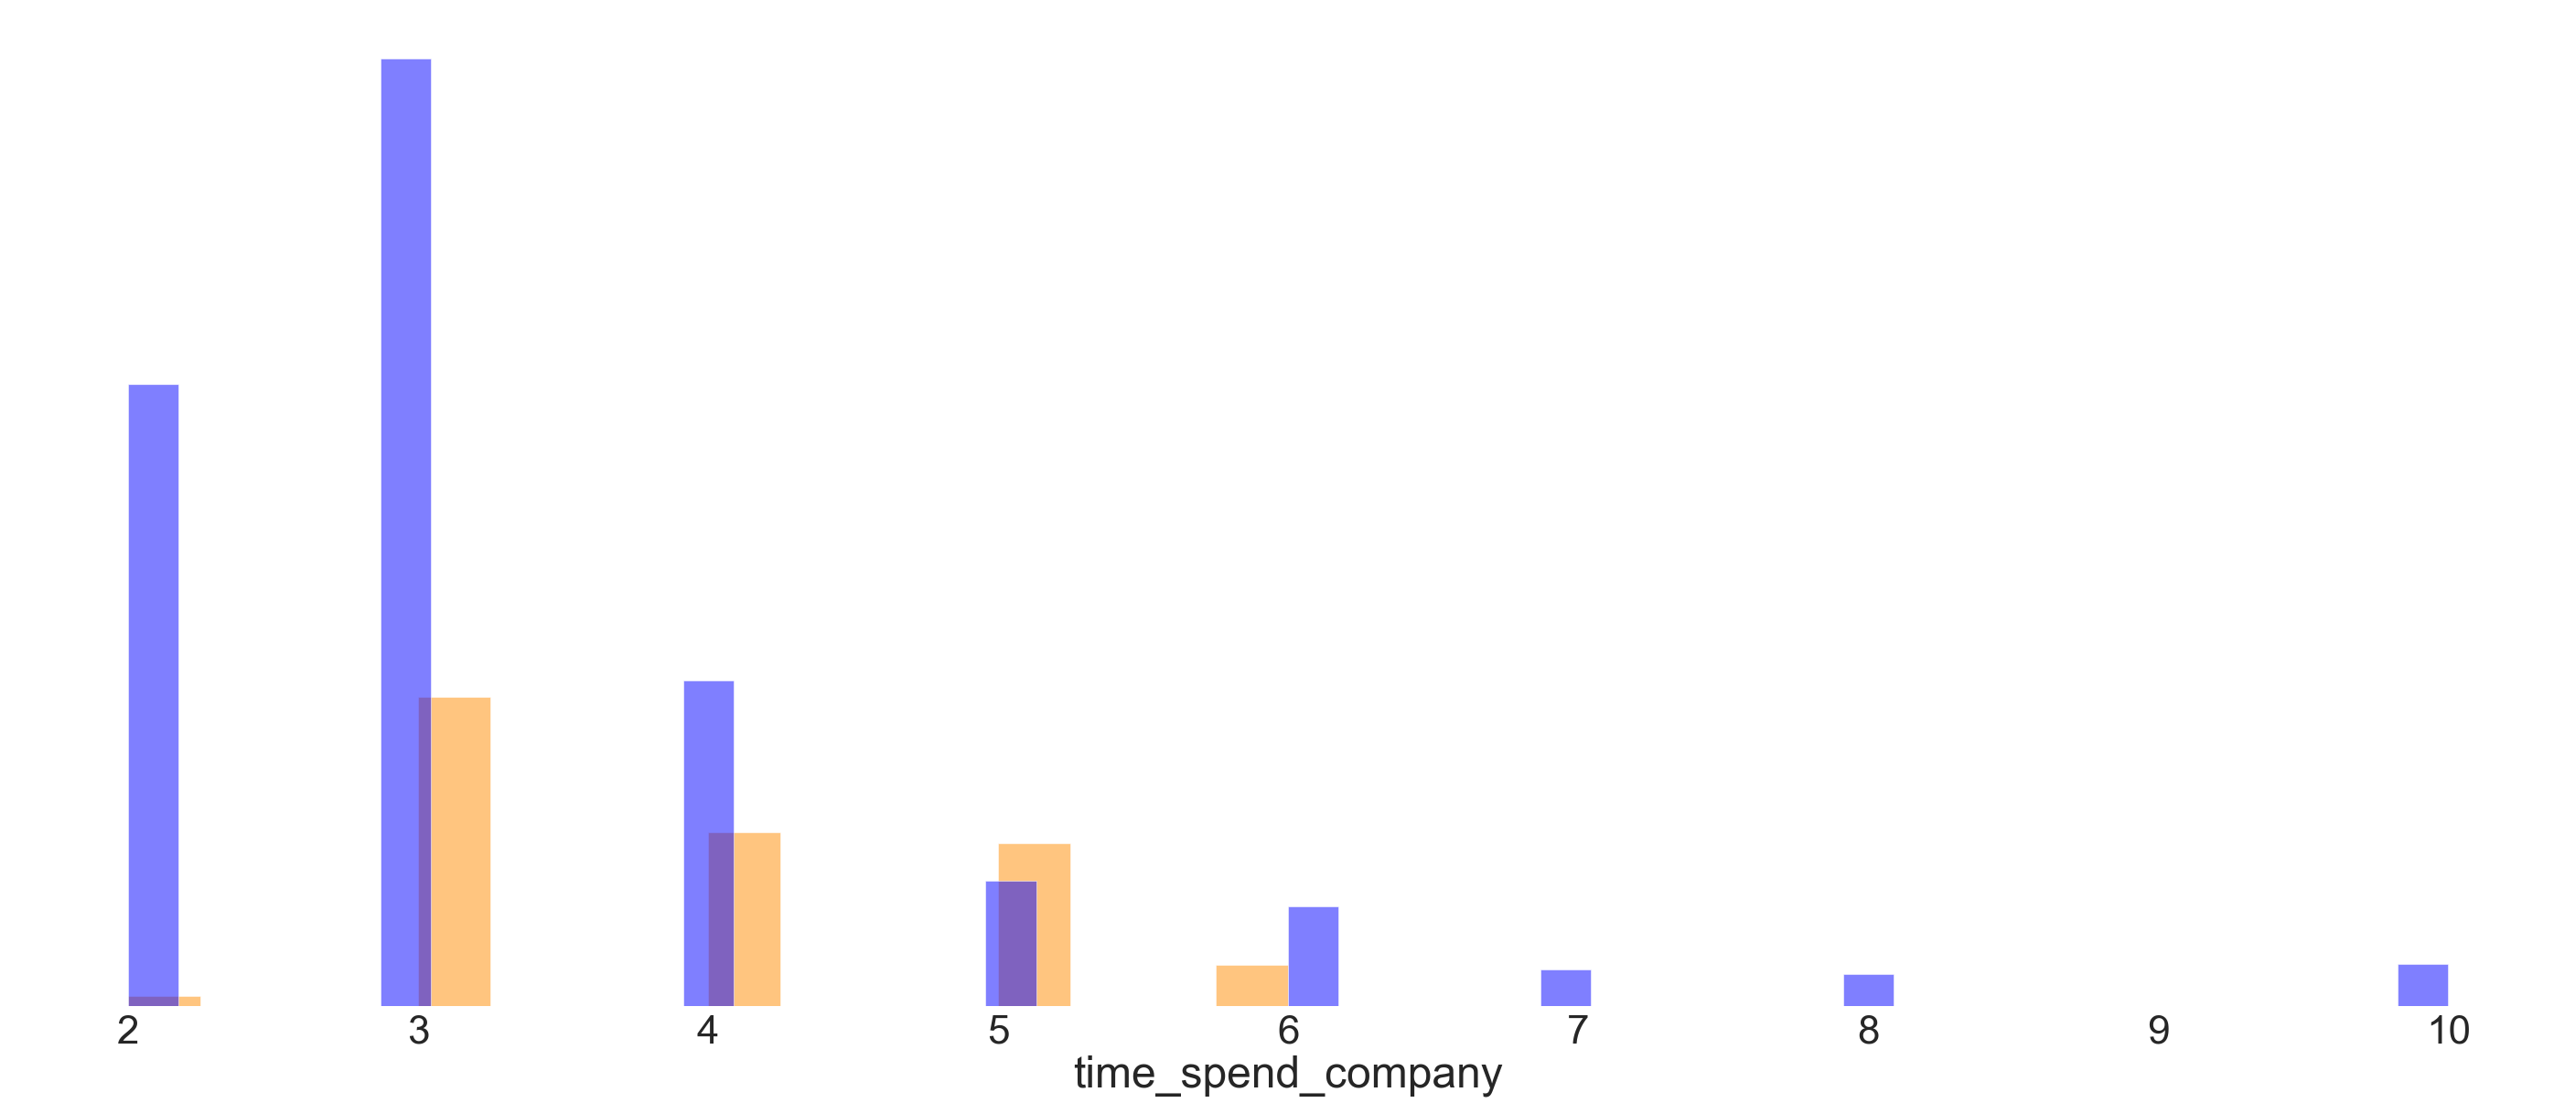

In [14]:
plotcols(cols2plot[3])

Before we run the baseline model, we need to check the correlation and get rid off the features are highly correlated to each others. As shown in the heatmap of the correlation matrix, the fields `average_montly_hours` and `number_project` have correlation `0.42`. Considering `0.4` as threshold, we decide to drop `average_montly_hours`.

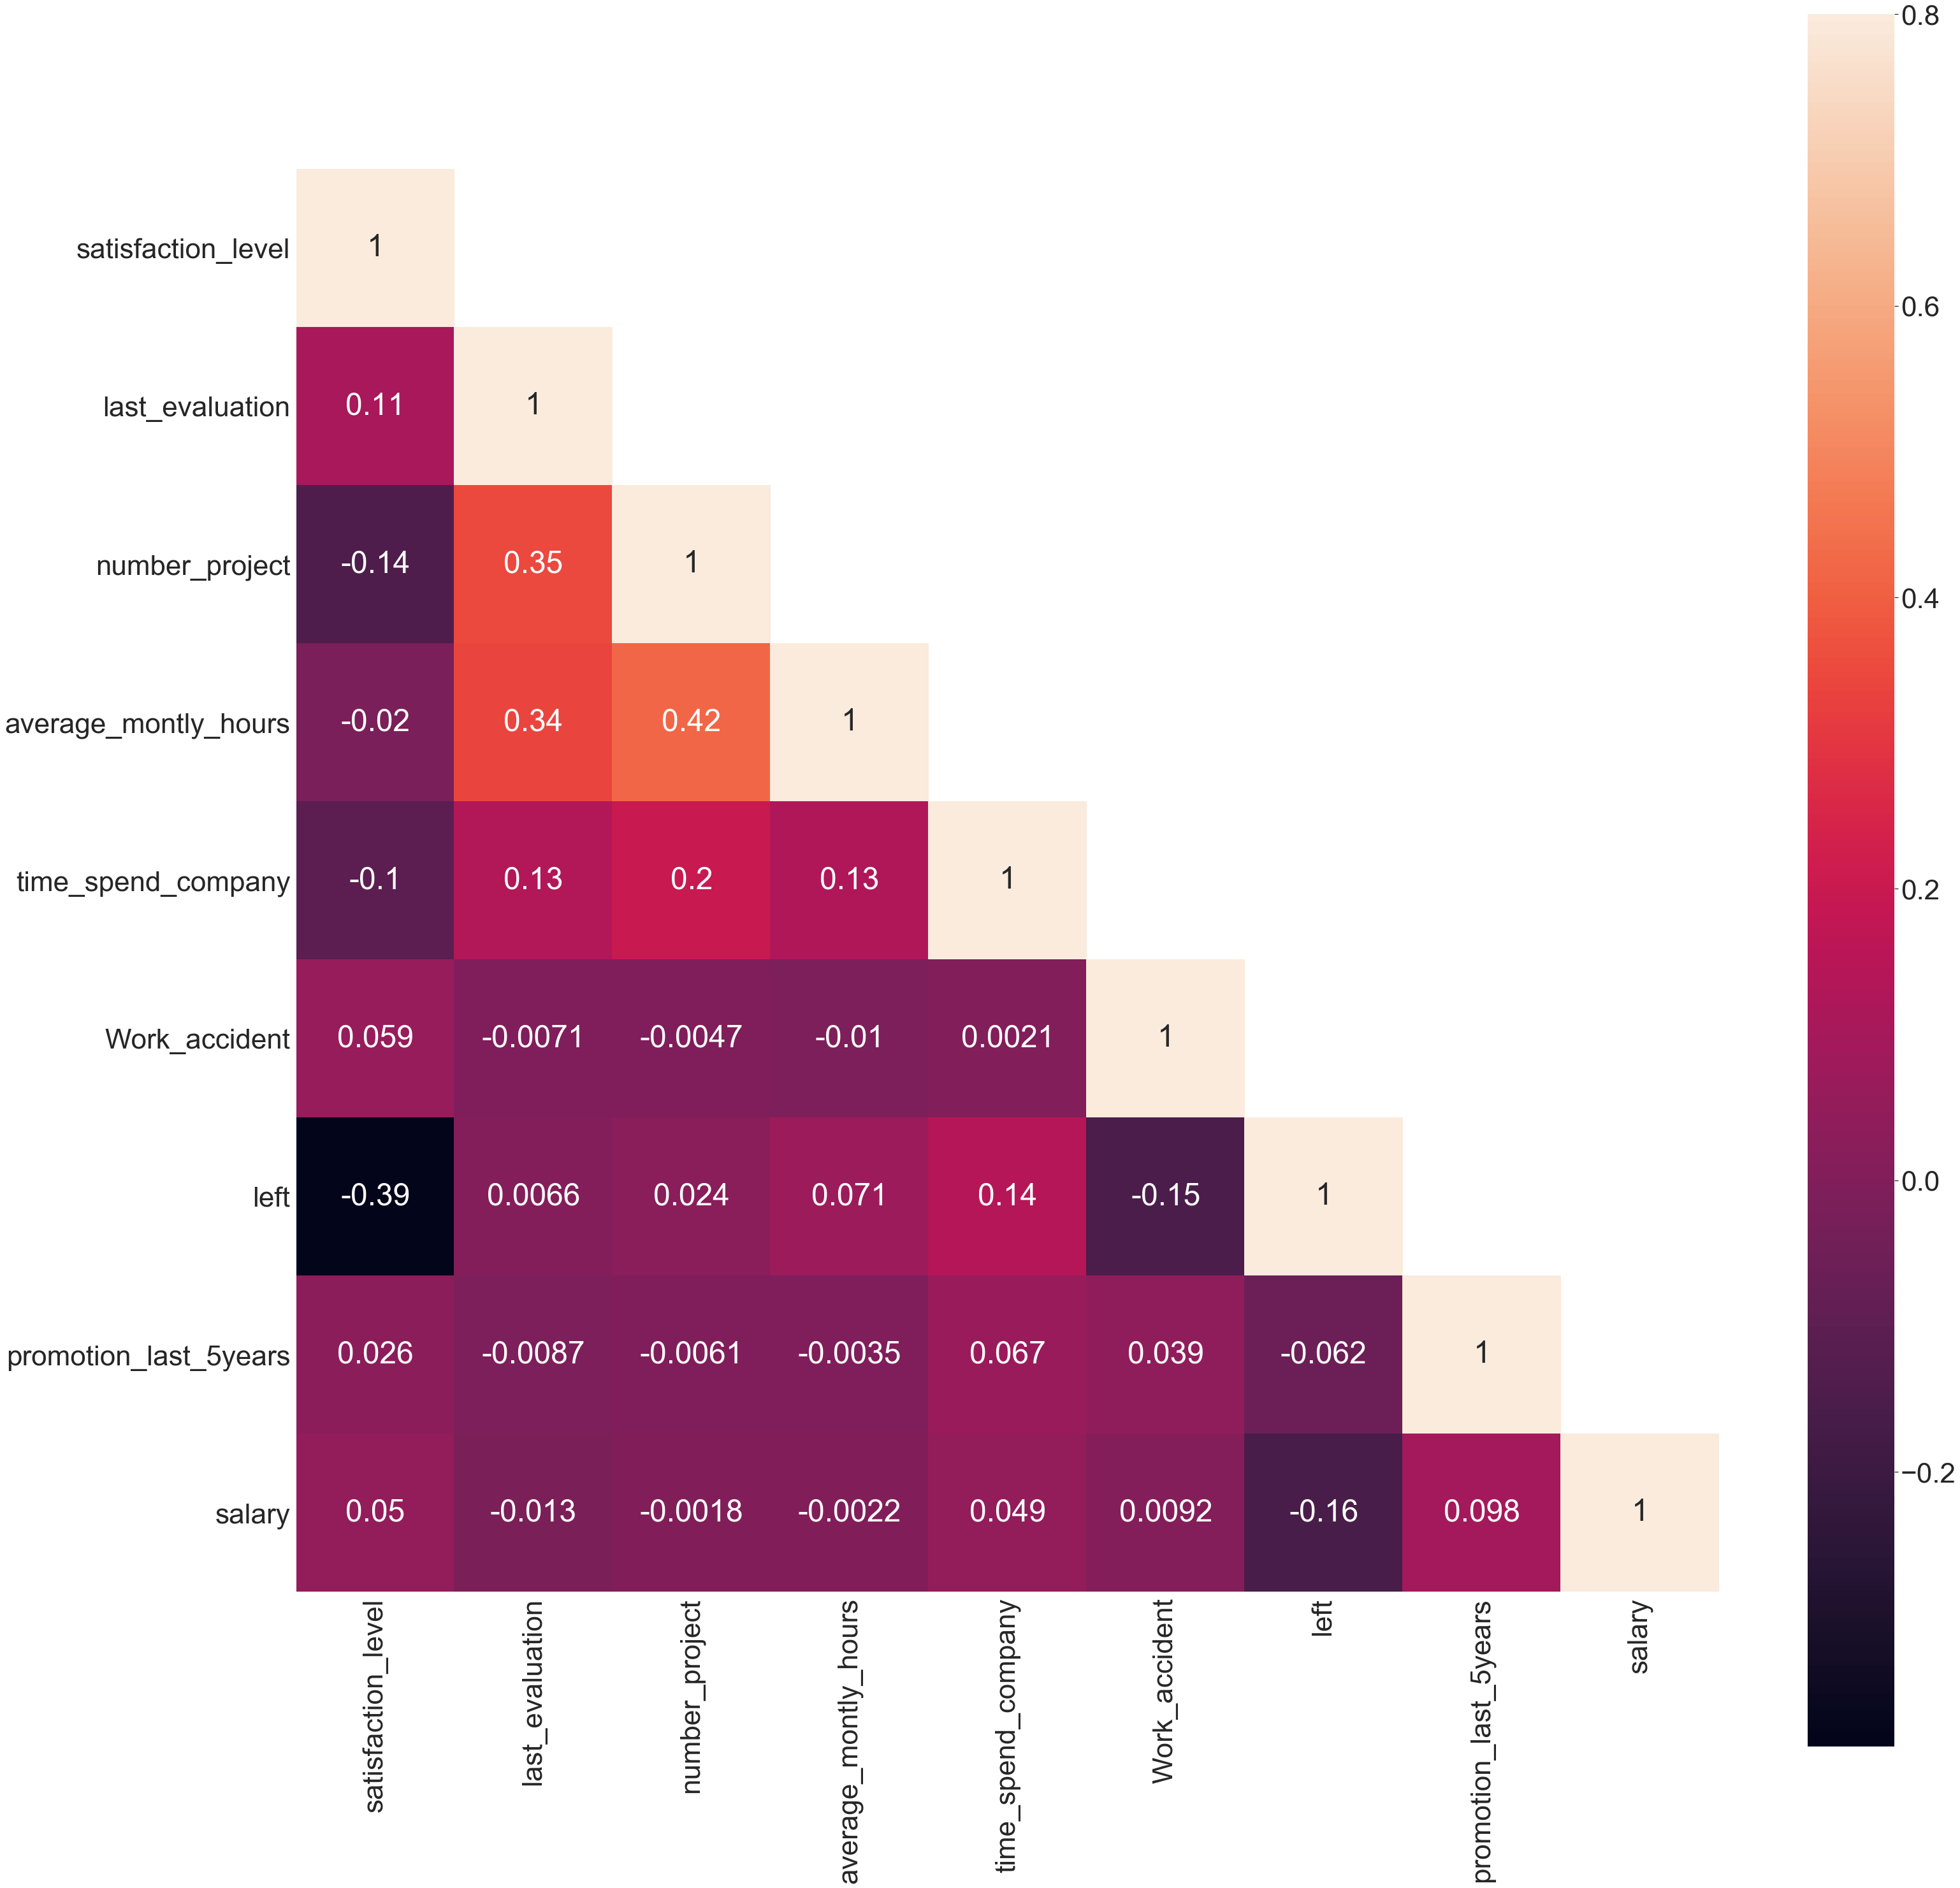

In [15]:
# @hidden_cell
# making a correlation heat map, skip the dummies
col4corr = [x for x in list(data_c.columns) if x not in dept_names]
corr_matrix = data_c[col4corr].corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots(figsize=(50,50))
sns.heatmap(corr_matrix, 
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            ax=ax)
plt.show()

cols2model = data_c.columns.tolist()
cols2model.remove('left')
cols2model.remove('average_montly_hours')

<a id="BaselineModel"></a>
## 4. Baseline Model<br>

As the field `average_montly_hours` is not used for modeling, and all the other features are either categorical or scaled in (0,1), so we don't have skewness in the features we are using for the baseline model. We randomly split the dataset into 80% of training set and 20% of holdout set, and use the training set for modeling. <br><br>
Then we apply cross validation to the model with the training set, to find the best model. In the cross validation process, the training set is randomly splited again into 80% of training and 20% of testing. We use the training set to fit the model, and the testing set to score the accuracy of the model. We repeat this process 10 times, and apply the model with the best accuracy to the holdout 20% dataset. Below is accuracy from our baseline model with cross validation process.<br><br>
Because the goal is to predict the employees' turnover, in which `left` is a binary variable with values 0 or 1, we decide to use Logistict Regression to predict the target `left`.<br><br>
With the baseline model, we are able to achieve the accurarcy of `0.80` on our holdout dataset. It means that this model has `80%` probability of correctly predict an employee's turnover.


In [16]:
def splitdataset(df,testsize=0.2, exclude=['left']):
    target = df.left
    features = df.loc[:, df.columns.difference(exclude)]
    target_train, target_test, features_train, features_test = \
            train_test_split(target,features,test_size=testsize,random_state=666,stratify=target) 
    return target_train, target_test, features_train, features_test

exclude = ['left','average_montly_hours']
target_train, target_test, features_train, features_test = splitdataset(data_c,exclude=exclude)


In [17]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)
pipeline0 = make_pipeline(
    LogisticRegression(random_state = 666, solver = 'lbfgs', max_iter=1000, n_jobs = -1)).\
                        fit(features_train, target_train)
scores = cross_val_score(pipeline0, features_train, target_train,
                         scoring="accuracy", cv=cv)

print('Obtained {} positive accuracy scores'.format(len(scores[scores > 0.0])))
print('Best CV accuracy: {:.2f}'.format(max(scores)))
print('Avg. CV accuracy: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('accuracy in hold-out dataset: {:.2f}'.format(
    pipeline0.score(features_test, target_test)))

Obtained 10 positive accuracy scores
Best CV accuracy: 0.82
Avg. CV accuracy: 0.80 +/- 0.01
accuracy in hold-out dataset: 0.80


write in here about one way for feature selection, and add it into pipeline

In [18]:
# feature selection
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(solver = 'lbfgs')
# featuresCols = [i for i in data_c.columns.tolist() if i != 'left']
# selector = RFE(model, 10)
# selector = selector.fit(data_c[featuresCols], data_c['left'])
# print(featuresCols)
# print(selector.support_)
# print(selector.ranking_)
# select_cols = ['satisfaction_level','average_montly_hours','Work_accident','promotion_last_5years','salary','accounting', 'hr','marketing','support', 'technical']

<a id="FeatureEngineering"></a>
## 5. Feature Enginnering<br>

As we mentioned in the [Data Visualization](#DataViz) part, the features such as `satisfaction_level`, `last_evaluation`, `time_spend_company` and `average_montly_hours` will be binned into intervals based on the pattern we discovered in the visualization. <br><br>
We bin the `satisfaction_level` with the width of 0.15, the `last_evaluation` with the width of 0.2, and the `time_spend company` with the width of 2.<br><br>
For the feature `average_montly_hours`, we fix the skewness by mapping the values into percentiles. As shown below, if we sort the values in ascending order, and take the minimum, 20th, 40th, 60th, 80th, and the maximum, we get a list of values with respect to each percentile. Based on the list, we bin the values into intervals such as `(20,40]`.

In [19]:
print('percentiles: [ 0 , 20 , 40 , 60 , 80 , 100 ]')
print('values:     ',np.percentile(data_c.average_montly_hours,[0, 20, 40, 60, 80, 100]))


percentiles: [ 0 , 20 , 40 , 60 , 80 , 100 ]
values:      [ 96. 150. 181. 220. 253. 310.]


Then those features will be preprocessed as categorical features like `depts` in the [Data Preparation](#DataPreparation) part.<br><br> Eventually, we get a new dataframe of 36 features.

In [20]:
def cut2cat(data,tagcol,thebin):
#use pd.cut function can attribute the values into its specific bins
    Cat = pd.cut(data[tagcol],bins=thebin).to_frame()
    new_column_name = tagcol[0:3] + 'Interval'
#     print(new_column_name)
    Cat.columns = [new_column_name]
    df = pd.concat([data,Cat],axis = 1)
    CatUnfold = pd.get_dummies(df[new_column_name],prefix=new_column_name)
    CatList = CatUnfold.columns
    CatUnfold = CatUnfold.drop(CatList[-1],axis=1)
    df = df.drop(new_column_name, axis = 1)
    df = df.drop(tagcol, axis = 1)
    df = pd.concat([df,CatUnfold],axis = 1)
    return df

sat_bins = [0,0.15,0.3,0.45,0.6,0.75,0.9,1]
eva_bins = [0,0.2,0.4,0.6,0.8,1]
time_bins = [0,2,4,6,8,10]
avghr_bins = np.percentile(data_c.average_montly_hours,[0, 20, 40, 60, 80, 100]).tolist()
dfn = cut2cat(data_c,'satisfaction_level',sat_bins)
dfn = cut2cat(dfn,'last_evaluation',eva_bins)
dfn = cut2cat(dfn,'time_spend_company',time_bins)
dfn = cut2cat(dfn,'average_montly_hours',avghr_bins)
dfn.head(10)
# print(avghr_bins)

,number_project,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,marketing,...,"lasInterval_(0.4, 0.6]","lasInterval_(0.6, 0.8]","timInterval_(0, 2]","timInterval_(2, 4]","timInterval_(4, 6]","timInterval_(6, 8]","aveInterval_(96.0, 150.0]","aveInterval_(150.0, 181.0]","aveInterval_(181.0, 220.0]","aveInterval_(220.0, 253.0]"
0,2,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,5,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,7,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
5,2,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
6,6,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
7,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,2,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


After generated the new dataframe with the new features, we select the best 20 features regarding to Chi-Square test. Chi-Square test measure the independence of the features, and it is capable of categorical or nominal values. At this point, our dataset only contians categorical and nominal features, so Chi-Square is a good measurement to use. <br><br>
Then we run the model with the same method we used in the [Baseline Model](#BaselineModel) part. The model achieves `0.93` accuracy on the holdout dataset, which means this model has 93% probability of correctly predict an employee's turnover.

In [21]:
# pipelines without polynomials
target_train, target_test, features_train, features_test = splitdataset(dfn, testsize=0.2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)
pipeline1 = make_pipeline(
    SelectKBest(chi2, k=20),
    LogisticRegression(random_state = 666, solver = 'lbfgs', max_iter=1000, n_jobs = -1)).\
                        fit(features_train, target_train)
scores = cross_val_score(pipeline1, features_train, target_train,
                         scoring="accuracy", cv=cv)

print('Obtained {} positive accuracy scores'.format(len(scores[scores > 0.0])))
print('Best CV accuracy: {:.2f}'.format(max(scores)))
print('Avg. CV accuracy: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('accuracy in hold-out dataset: {:.2f}'.format(
    pipeline1.score(features_test, target_test)))

Obtained 10 positive accuracy scores
Best CV accuracy: 0.94
Avg. CV accuracy: 0.93 +/- 0.0047
accuracy in hold-out dataset: 0.93


To improve the accurarcy of the model, we introduce polynomials to our pipeline. Polynomial features present the multiple degrees of a feature, and it also present the interaction in different features. <br><br>
For example, `number_project`*`Work_accident` present the interaction between the number of projects the employee has done, and if he had any work accident. When `number_project=2` and `Work_accident=0`, it means this employee had two projects and none work accident. The square of `number_project`prensents its quadratic influence to the model.<br><br>
In this pipeline, we still use Chi-Square to select the features for modeling. However, as polynomials generates more features, we select the best 100 features instead. With the Logistic Regression model, we are able achieve `0.96` accuracy on the holdout dataset. This time, our model has `96%` probability of correctly predicting the employee's turnover.

In [22]:
#pipeline with poly
target_train, target_test, features_train, features_test = splitdataset(dfn, testsize=0.2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)
pipeline2 = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    SelectKBest(chi2, k=100),
    LogisticRegression(random_state = 666, solver = 'lbfgs', max_iter=1000, n_jobs = -1)).\
                        fit(features_train, target_train)
scores = cross_val_score(pipeline2, features_train, target_train,
                         scoring="accuracy", cv=cv)

print('Obtained {} positive accuracy scores'.format(len(scores[scores > 0.0])))
print('Best CV accuracy: {:.4f}'.format(max(scores)))
print('Avg. CV accuracy: {:.4f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('accuracy in hold-out dataset: {:.4f}'.format(
    pipeline2.score(features_test, target_test)))

Obtained 10 positive accuracy scores
Best CV accuracy: 0.9646
Avg. CV accuracy: 0.9567 +/- 0.0049
accuracy in hold-out dataset: 0.9553


<a id='FinalMetric'></a>
## 6. Final Metric <br>
As we selecting more features in the pipeline, we are able to boost the accuracy more. We run the same pipeline with different number of features being selected based on Chi-Square. From accuracy we collected by iterating the pipeline with increased number of features, we are able to tell that with the more features, the model's accuracy improved from blah to blah. But when the number of features reaches 350, the accuracy on the test dataset reaches 0.9633, the model is not able to be improved anymore.<br><br>
Therefore, we decide to use the 350 best features for our final model. The final model is able to achieve 96.33% of the accuracy on predicting an employee's turnover.

In [136]:
best_train_accuracy = {}
test_accuracy = {}
target_train, target_test, features_train, features_test = splitdataset(dfn, testsize=0.2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=123)

for k in range(100,500,50):
    pipeline2 = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False), 
        SelectKBest(chi2, k=k),
        LogisticRegression(random_state = 666, solver = 'lbfgs', max_iter=1000, n_jobs = -1)).\
                            fit(features_train, target_train)
    scores = cross_val_score(pipeline2, features_train, target_train,
                             scoring="accuracy", cv=cv)
    best_train_accuracy[k] = max(scores)
    test_accuracy[k] = pipeline2.score(features_test, target_test)

Number of Features: 350
Best Training Accuracy: 0.9683
Best Testing Accuracy: 0.9633


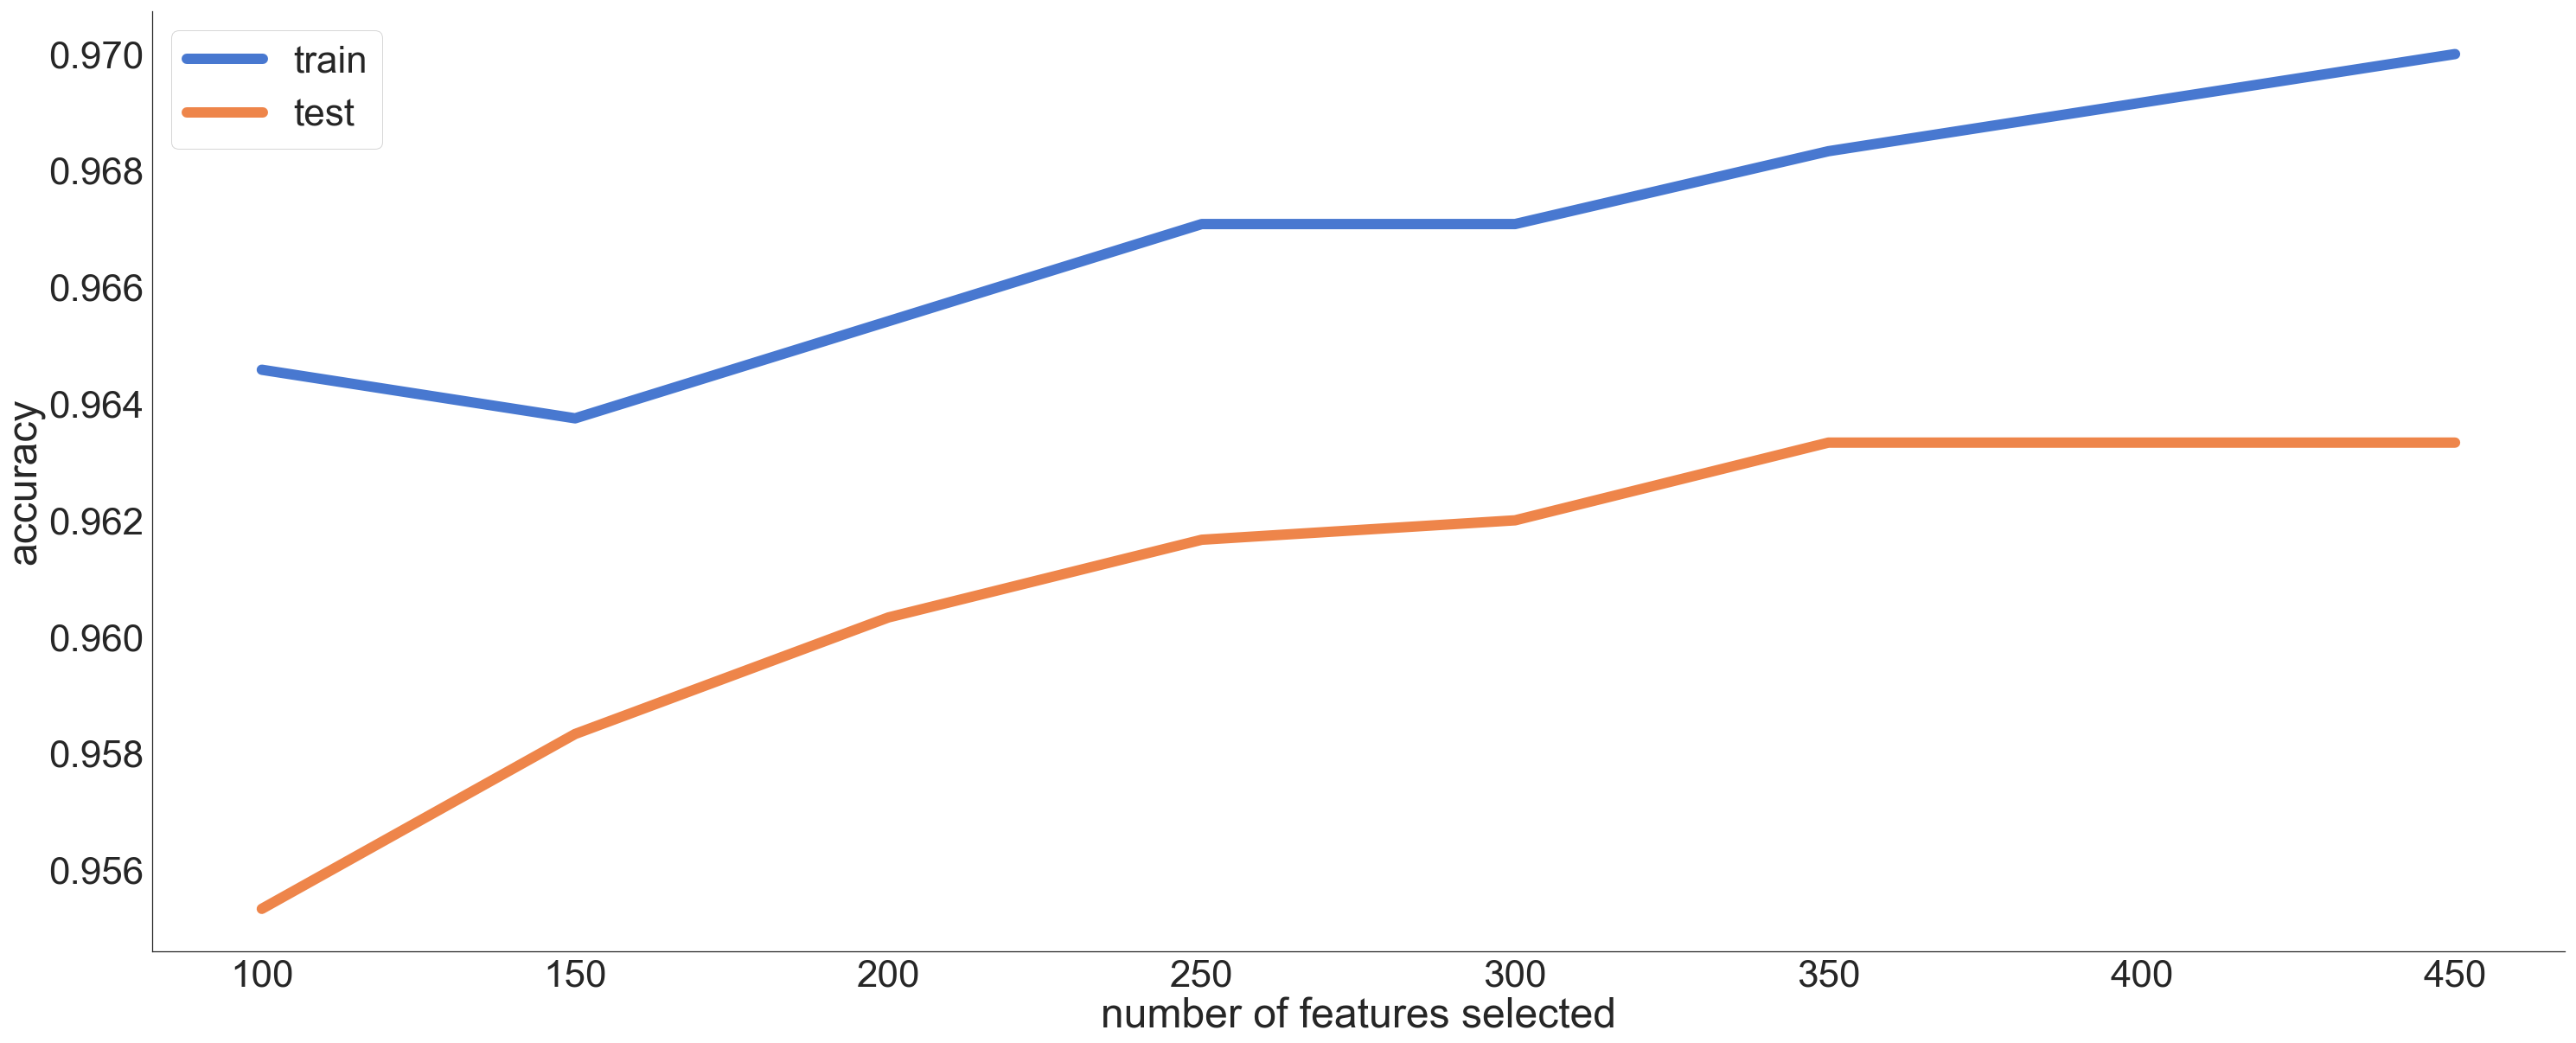

In [165]:
dict_accuracy = {'k': [k for k in range(100,500,50)], 
                 'train':[v for k,v in best_train_accuracy.items()],
                 'test':[v for k,v in test_accuracy.items()]}

df_acc = pd.DataFrame.from_dict(dict_accuracy)
sns.set(style="white", palette="muted", color_codes=True, font_scale=4)
f, axes = plt.subplots(1, 1, figsize=(50, 20), sharex=True)
splot1 = sns.lineplot(x=df_acc.k, y=df_acc.train, label='train', lw=12)
splot2 =  sns.lineplot(x=df_acc.k, y=df_acc.test, label='test', lw=12)
axes.set_ylabel('accuracy')
axes.set_xlabel('number of features selected')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
print('Number of Features: 350')
print('Best Training Accuracy: {:.4f}'.format(df_acc.train[df_acc.k==350].values[0]))
print('Best Testing Accuracy: {:.4f}'.format(df_acc.test[df_acc.k==350].values[0]))
plt.show()


In [169]:
# cols2cluster = ['satisfaction_level', 'last_evaluation', 'number_project','average_montly_hours',
#                 'time_spend_company', 'Work_accident', 'promotion_last_5years']
# # cols2cluster = ['satisfaction_level', 'last_evaluation', 'number_project']
# for col1 in cols2cluster:
#     for col2 in cols2cluster:
#         if col1 != col2:
#             sns.scatterplot(x=col1, y=col2, hue="left",data=dfn)
#             plt.show()